# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("/Users/luca/anaconda2/Springboard/data/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("/Users/luca/anaconda2/Springboard/data/WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
#merge dataframes into new dataframe
df=pd.merge(df_transactions,df_offers,on='offer_id')

#pivot so that each offer has a column with 0 or 1
df_table=df.pivot_table(index='customer_name',columns=['offer_id'],values='n',fill_value=0).reset_index()

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

# your turn
The smaller the SS the better. A small SS means that the cluster is grouped very tightly around a centroid. A large SS means that the points vary from the centroid which means your cluster is more spread out. We would like to see well developed clusters that are clearly defined. 

In [5]:
#drop non-feature columns
x_cols=df_table.drop('customer_name',axis=1) 
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


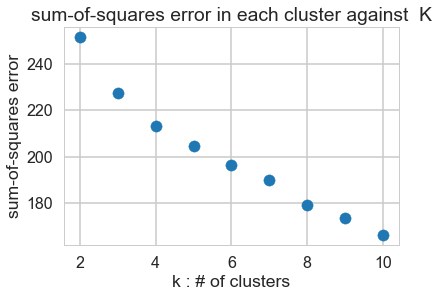

In [6]:
#import cluster model KMeans
from sklearn.cluster import KMeans

#ranges to test for cluster
k_range=[i for i in xrange(2,11)]

#list to hold sum-of-squares error
ss=[]

#loop over cluster values to find sum-of-squares error
for k in k_range:
    model=KMeans(n_clusters=k)
    
    #fit KMeans on matrix with out customer names
    model.fit(x_cols)
    
    #add sum-of-squares error to appropriate list
    ss.append(model.inertia_)
    
#Construct a plot showing  SS for each  K
plt.scatter(k_range,ss)
_ = plt.xlabel('k : # of clusters')
_ = plt.ylabel('sum-of-squares error')
_ = plt.title('sum-of-squares error in each cluster against  K')

plt.show()

Using this chart we five looks like a good point to consider for an elbow. Hence, we select k = 5 for the model's cluster number.  

## Make a bar chart showing the number of points in each cluster for k-means under the best  K

## What challenges did you experience using the Elbow method to pick  K

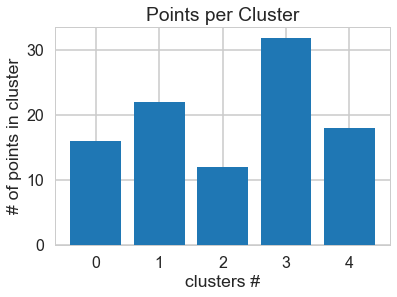

In [51]:
#import a counter for the points
from collections import Counter

#make an instance of the KMeans with 5 clusters
model=KMeans(n_clusters=5)

#fit KMeans on matrix with out customer names
model.fit(x_cols)

#save the labels per point to an array
points=model.labels_
#count the number of points labeled for each cluster
plot_points=Counter(points)

#plot the barchart of points per cluster

#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_points)),list(plot_points.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_points)),list(plot_points.keys()))

#add labels and title
_ = plt.xlabel('clusters #')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per Cluster')

plt.show()

Picking the elbow point is very subjective. The elbow is not very pronounced, and a case could be made for using several different cluster numbers.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

('For n_clusters =', 2, 'The average silhouette_score is :', 0.093655732834927133)


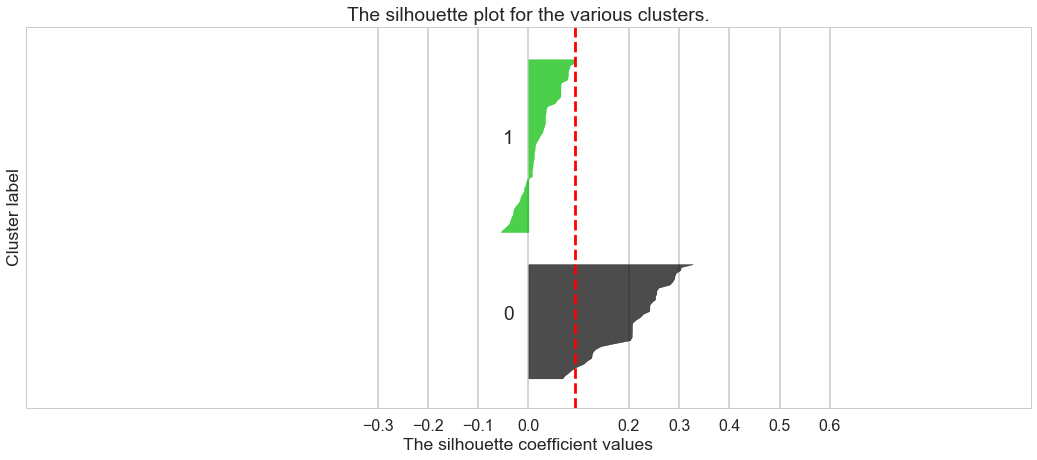

('For n_clusters =', 3, 'The average silhouette_score is :', 0.11889942863638556)


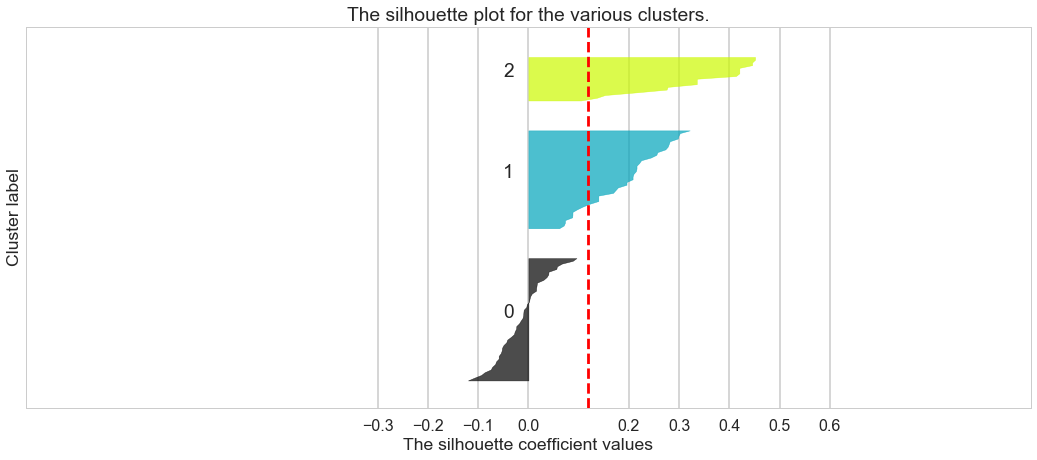

('For n_clusters =', 4, 'The average silhouette_score is :', 0.12347053919571699)


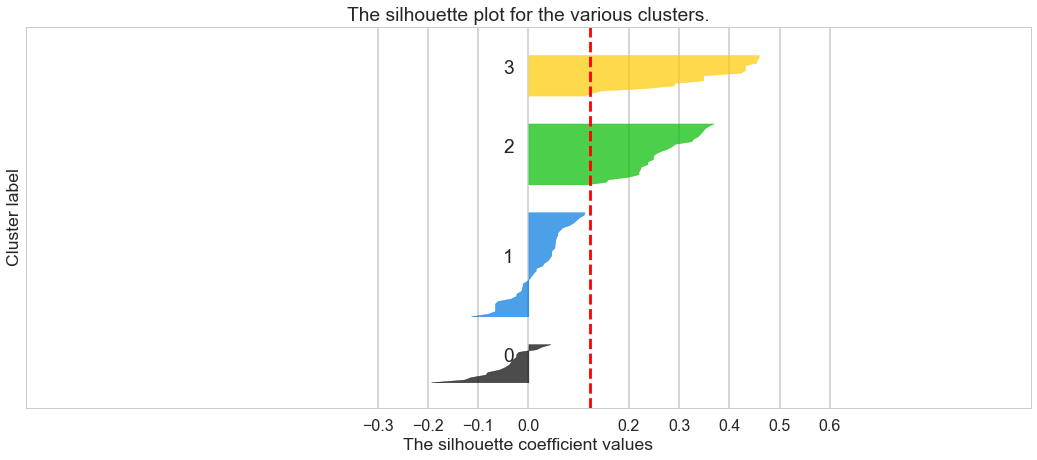

('For n_clusters =', 5, 'The average silhouette_score is :', 0.14092516241984757)


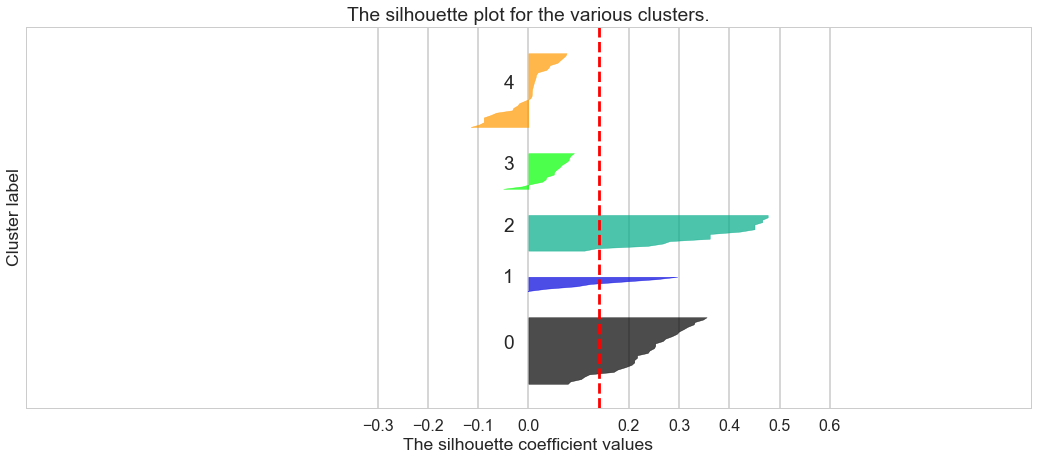

('For n_clusters =', 6, 'The average silhouette_score is :', 0.1371798939109807)


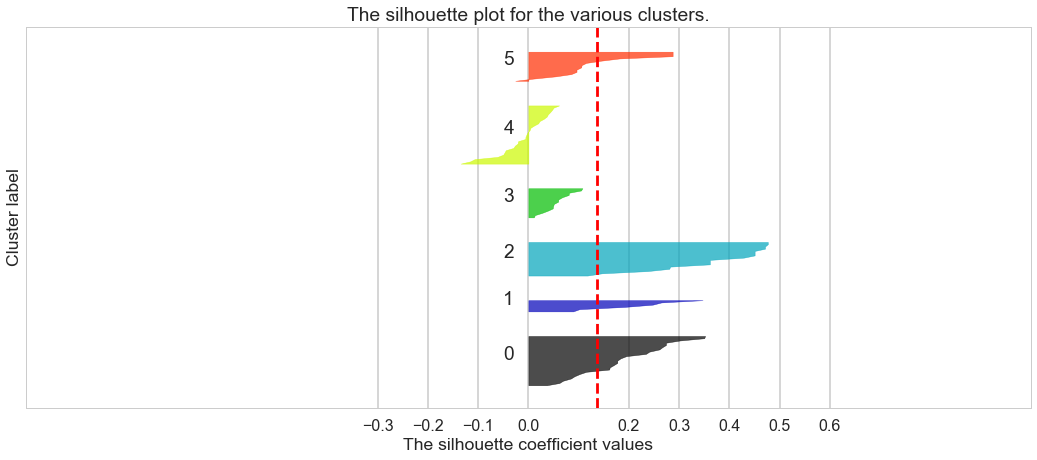

('For n_clusters =', 7, 'The average silhouette_score is :', 0.1161092456616906)


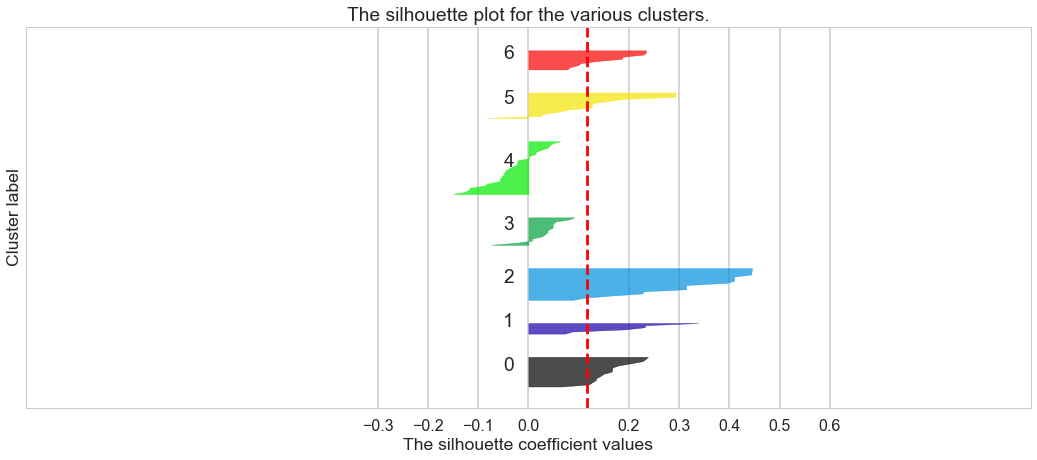

('For n_clusters =', 8, 'The average silhouette_score is :', 0.11339573832632867)


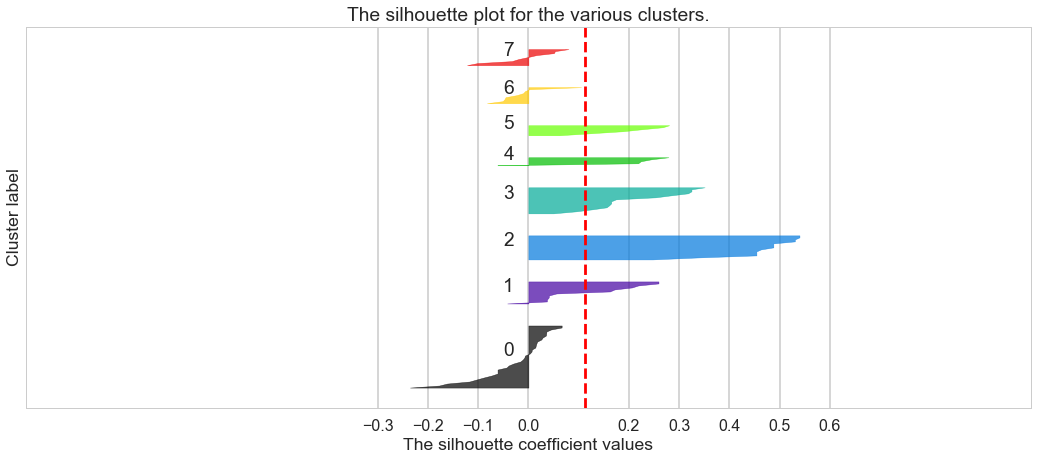

('For n_clusters =', 9, 'The average silhouette_score is :', 0.12505960527779877)


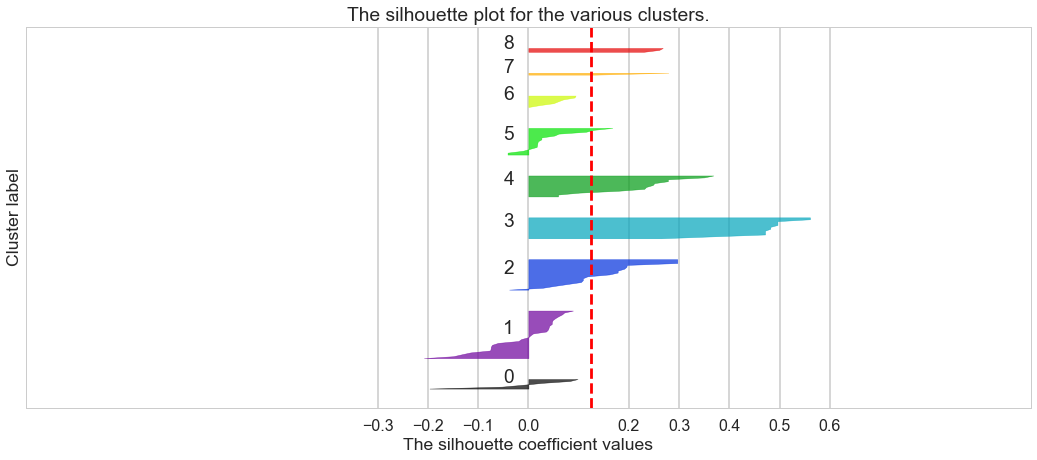

('For n_clusters =', 10, 'The average silhouette_score is :', 0.11928332134753233)


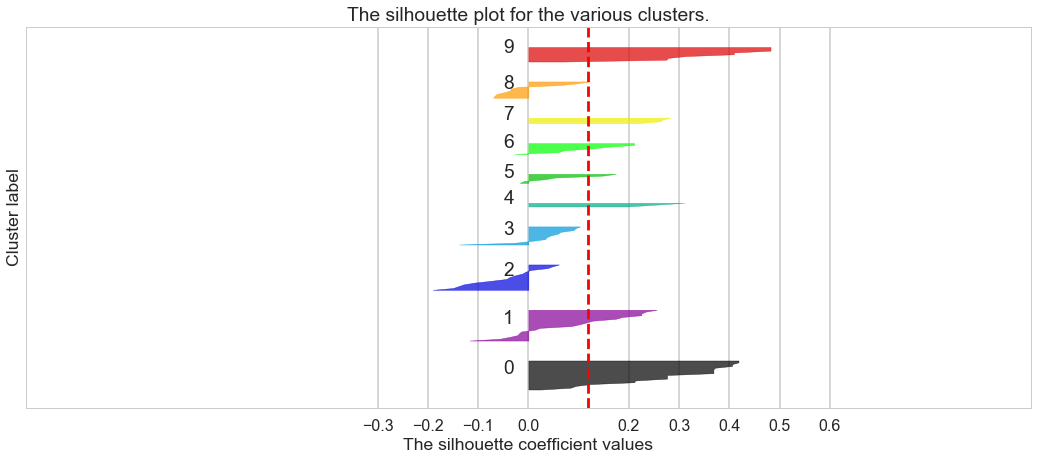

the best number of clusters is 5 with a silhouette_avg of 0.14092516242


In [8]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#set cluster numbers to try
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

#best score holder for k clusters
best_cluster_score=0

#variable to store the best value for k
best_k=0

#loop over cluster numbers to find the best 
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    #capture the best value for the silhouette score and cluster number
    if silhouette_avg > best_cluster_score:
        best_cluster_score = silhouette_avg
        best_k = n_clusters
   
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        #make the size for each cluster on the graph
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #add color to each cluster
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #add labels and title
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #set the ticks for y and x
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3,-0.2,-0.1, 0, 0.2,0.3,0.4,0.5,0.6])
    

    plt.show()
    
#print the best cluster overall along with score
print("the best number of clusters is {} with a silhouette_avg of {}".format(best_k,best_cluster_score))



In [9]:
#lets save the scores of each cluster method for comparison later
scores_overall={}
scores_overall['naive_bayes']=best_cluster_score

## What  K does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

The silhouette method reaffirms that we picked well using the elbow method. Five is the best number for n_clusters. IT is worth noting that the silhouette method is much less subjective and leaves the modeler with a quantative reason to choose five over the other values in consideration. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [10]:
#your turn
from sklearn.decomposition import PCA

#create a PCA instance
model=PCA(n_components=2)

#fit and transform data with pca model
pca_features=model.fit_transform(x_cols)

#capture values of 1st pca component
x=pca_features[:,0]

#capture values of 2nd pca component
y=pca_features[:,1]

#create dataframe with costumer names
df_pca=df_table[df_table.columns[:1]]

#add column for 1st pca component
df_pca['x']=x

#add column for 2nd pca component
df_pca['y']=y

#add column for cluster points based of 5 clusters from before
df_pca['cluster_id']=points

df_pca.head()

/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

offer_id,customer_name,x,y,cluster_id
0,Adams,1.007580,0.108215,2
1,Allen,-0.287539,0.044715,1
2,Anderson,-0.392032,1.038391,3
3,Bailey,0.699477,-0.022542,2
4,Baker,0.088183,-0.471695,1


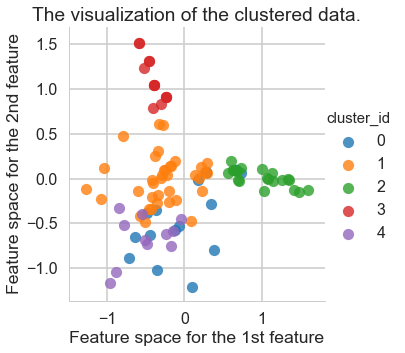

In [11]:
#import some nicer plotting packages
import seaborn as sns

#plot x and y columns of dataframe with color by cluster id
sns.lmplot('x','y', data=df_pca , hue='cluster_id',legend=True, fit_reg=False)

#add labels and title
plt.title("The visualization of the clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")

plt.show()

We have used PCA to reduce the dimensionality down to two components for easy plotting. We see here that in 2-D the optimal n_cluster=5 for both the elbow and the silhouette does do a good job. of breaking the points into clusters. It is worth noting that cluster centers 4, 3 and 1 have quite a bit of overlap. It might be better to combine these there into one and use three clusters instead of 5. However, remember this is a projection onto the 2-D plane. The data could be much better separated in higher dimensions, and the reason the other method choose 5 clusters instead of 3. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

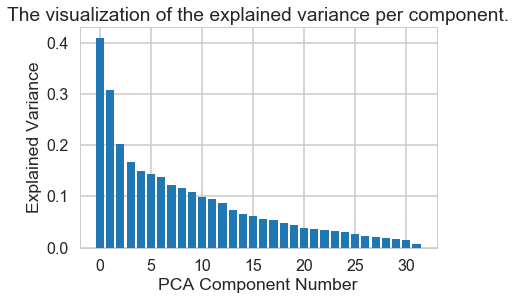

In [12]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition

#make instance of PCA
pca = sklearn.decomposition.PCA()

#fit model to data
pca.fit(x_cols)

# Do the rest on your own :)
#get the range of pca components for plotting
features=range(pca.n_components_)
var=pca.explained_variance_ 

#plot explained variance per component 
plt.bar(features, var)
plt.tight_layout()

#add label and title
plt.title("The visualization of the explained variance per component.")
plt.xlabel("PCA Component Number")
plt.ylabel("Explained Variance")

plt.show()

We see from this bar plot of component variance that the elbow turn, the point at which the variance per component slows, is around 3. After 3, each component captures much less of the variance. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


We will try using the sklearn algorithm straight out of the box first. Then we will tune the parameters a bit. At the end, we will compare the algorithms based off of the 2-D PCA visualization and the silhouette score we saw above. 

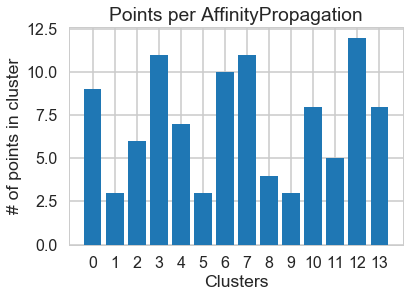

In [68]:
# Your turn
from sklearn.cluster import AffinityPropagation

#make an instance of the Affinity Propagation with default parameters, damping 0.5 and euclidean distance, preference 
# set to median by default
model=AffinityPropagation()

#fit: create affinity matrix from neg euclidean distances then apply affinity propagation clustering
model.fit(x_cols)

#save the labels per point to an array
labels=model.labels_

#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#plot the barchart of points per cluster
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_labels)),list(plot_labels.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_labels)),list(plot_labels.keys()))


_ = plt.xlabel('Clusters')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per Affinity Propagation')

In [54]:
#create dataframe with costumer names
df_pca['cluster_af']=labels

/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


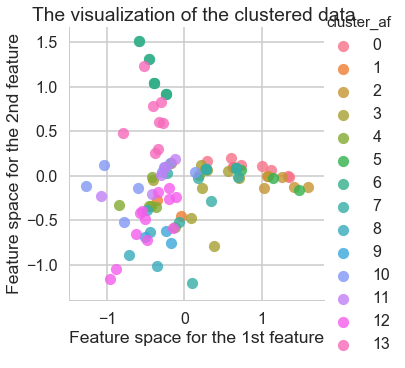

In [55]:
#plot x and y columns of dataframe with color by cluster id
sns.lmplot('x','y', data=df_pca , hue='cluster_af',legend=True, fit_reg=False)

#add labels and title
plt.title("The visualization of the clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

In [16]:
#fit and predict the labels to score
cluster_labels = model.fit_predict(x_cols)

#calculate teh silhouette score for Affinity Cluster Method
silhouette_avg_af = silhouette_score(x_cols, cluster_labels)
print("For Affinity Cluster the average silhouette_score is :", silhouette_avg_af)

#save score for comparison later
scores_overall['Affinity Cluster']=silhouette_avg_af

('For Affinity Cluster the average silhouette_score is :', 0.12346523604478911)


Lets do a Spectral Clustering next. Per Sklearn documentation, this is best used for highly non-convex clusters. It takes into account that the spread of the cluster or shape from the center might not be the best measure for determining clusters. Example nested circles. Under the hood it uses a projection to the normalized laplacian. We have normally one parameter to tune, number of clusters. We will do first out of the box and then tune the parameter. 


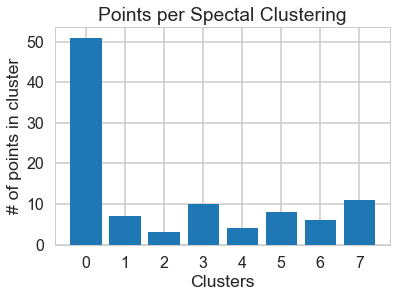

In [67]:
from sklearn.cluster import SpectralClustering


#make an instance of the Spectal Clustering 
model=SpectralClustering()

#fit: create affinity matrix from neg euclidean distances then apply affinity propagation clustering
model.fit(x_cols)

#save the labels per point to an array
labels=model.labels_

#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#plot the barchart of points per cluster
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_labels)),list(plot_labels.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_labels)),list(plot_labels.keys()))


_ = plt.xlabel('Clusters')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per Spectal Clustering')

('For n_clusters =', 2, 'The average silhouette_score is :', 0.059140597017205601)


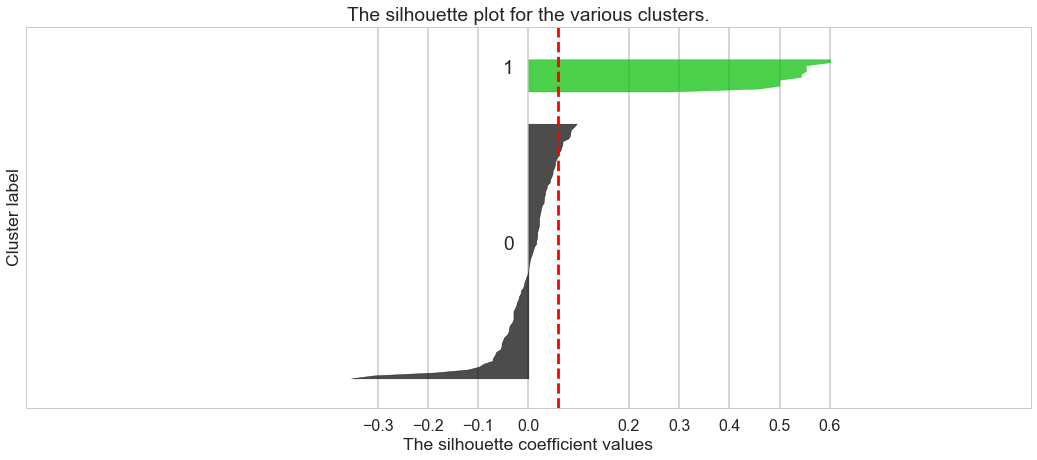

('For n_clusters =', 3, 'The average silhouette_score is :', 0.099905912310245787)


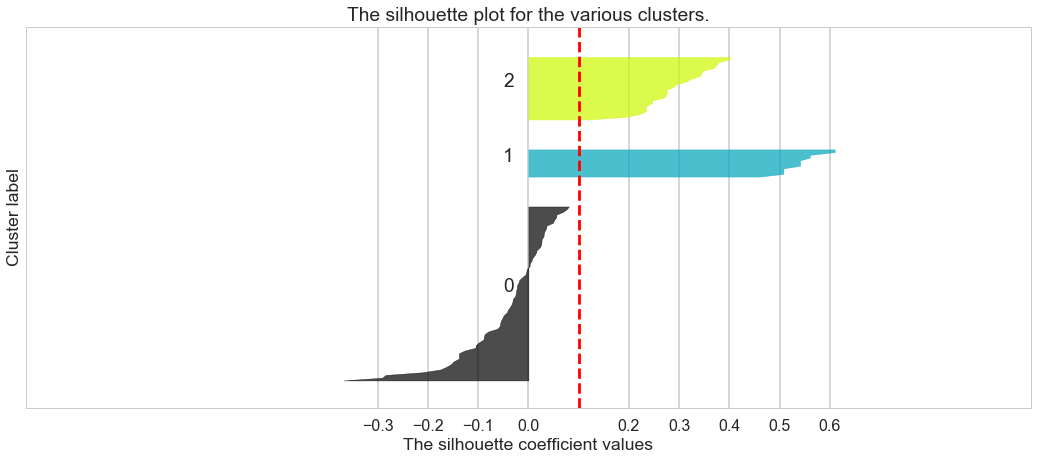

('For n_clusters =', 4, 'The average silhouette_score is :', 0.029065698932750638)


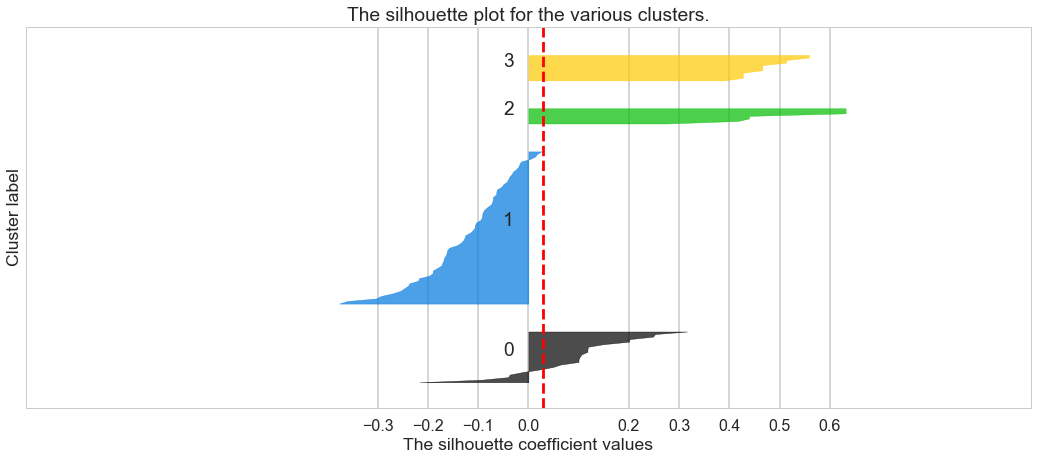

('For n_clusters =', 5, 'The average silhouette_score is :', 0.015856768776882108)


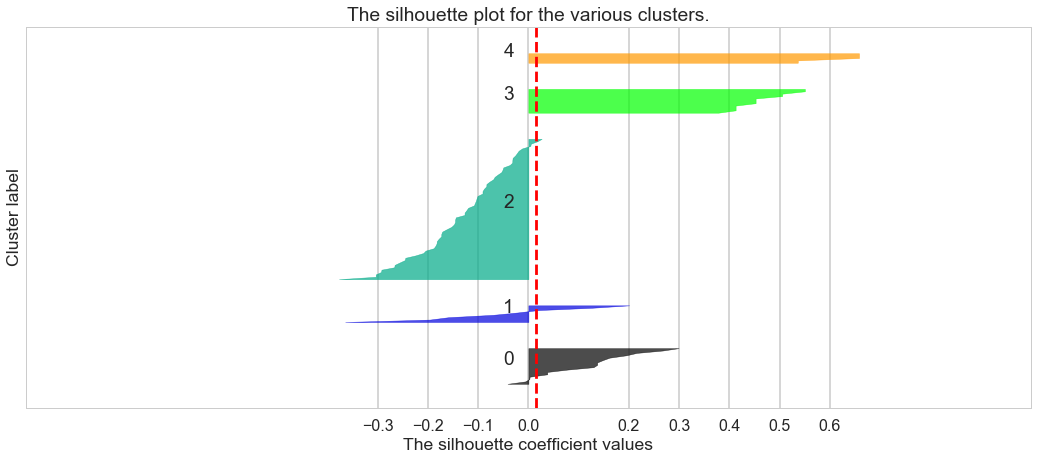

('For n_clusters =', 6, 'The average silhouette_score is :', 0.047137791897886833)


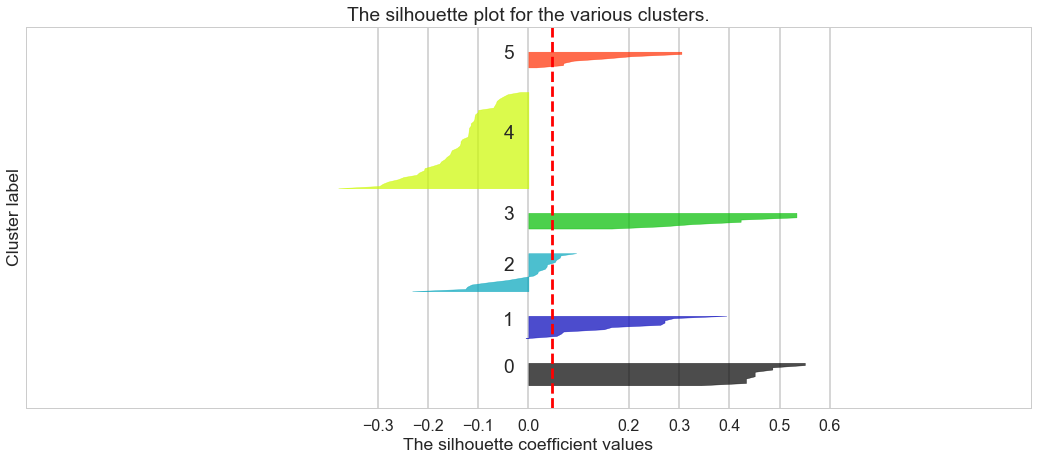

('For n_clusters =', 7, 'The average silhouette_score is :', 0.044458787005486708)


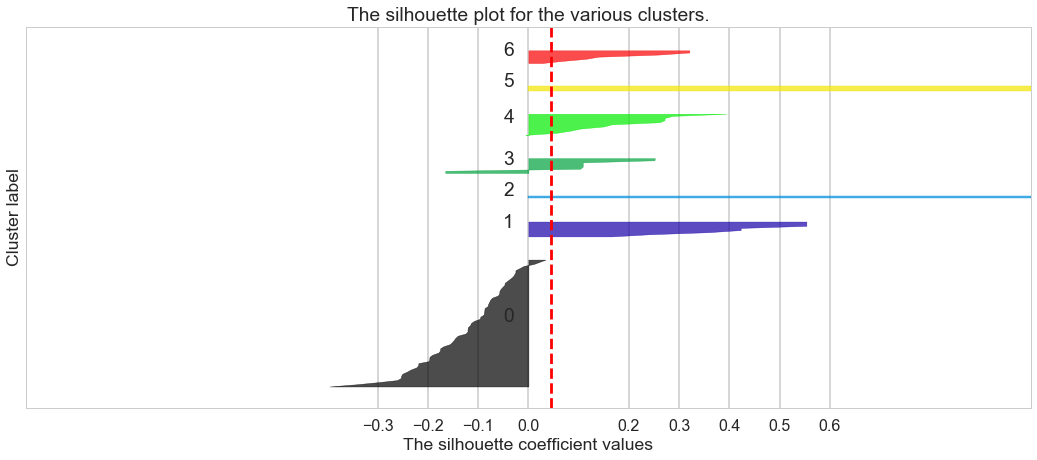

('For n_clusters =', 8, 'The average silhouette_score is :', 0.057245478221603904)


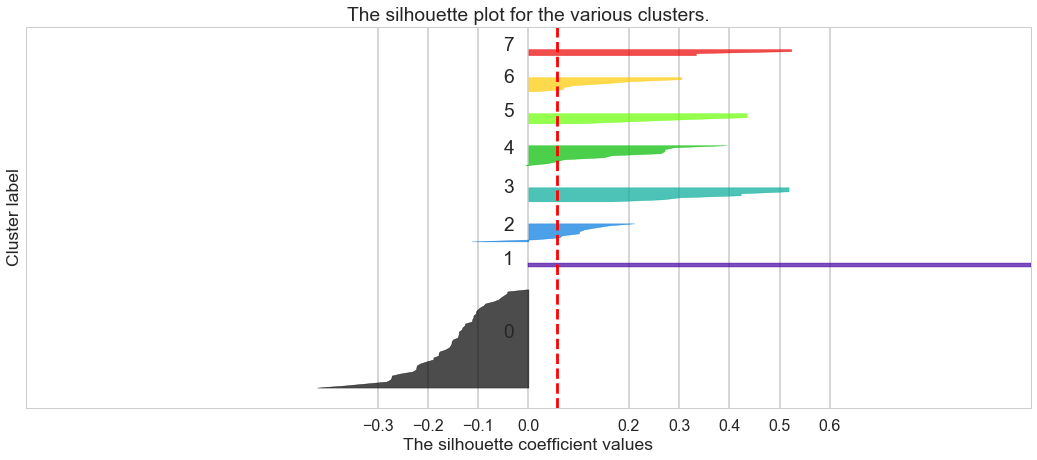

('For n_clusters =', 9, 'The average silhouette_score is :', 0.035908203430191465)


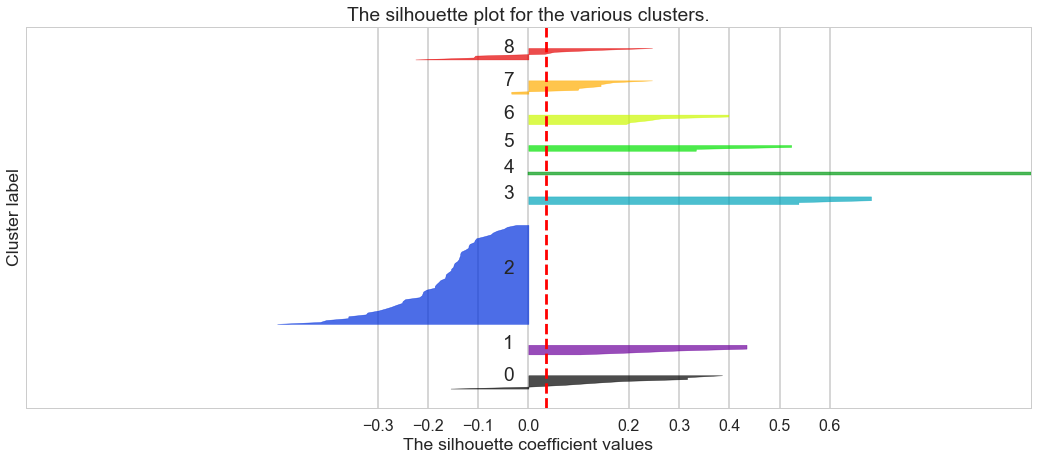

('For n_clusters =', 10, 'The average silhouette_score is :', 0.053638542629376978)


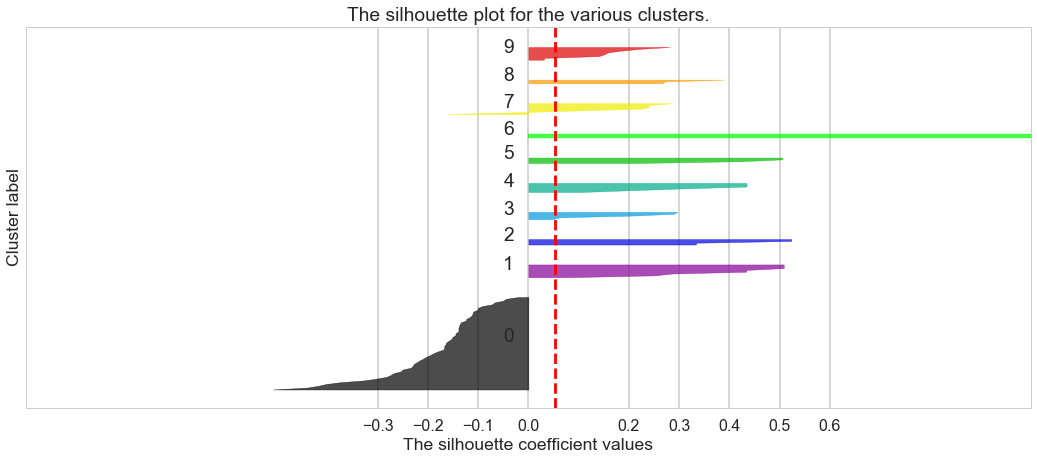

the best number of clusters is 3 with a silhouette_avg of 0.0999059123102


In [18]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

#best score holder for k clusters
best_cluster_score=0

#variable to store the best value for k
best_k=0

#loop over cluster numbers to find the best 
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = SpectralClustering(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    #capture the best value for the silhouette score and cluster number
    if silhouette_avg > best_cluster_score:
        best_cluster_score = silhouette_avg
        best_k = n_clusters
   
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        #make the size for each cluster on the graph
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #add color to each cluster
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #add labels and title
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #set the ticks for y and x
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3,-0.2,-0.1, 0, 0.2,0.3,0.4,0.5,0.6])
    

    plt.show()
    
#print the best cluster overall along with score
print("the best number of clusters is {} with a silhouette_avg of {}".format(best_k,best_cluster_score))




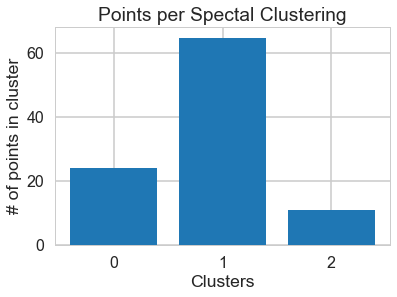

In [66]:
#make an instance of the Spectal Clustering 
model=SpectralClustering(n_clusters=3)

#fit Spectal Clustering to data
model.fit(x_cols)

#save the labels per point to an array
labels=model.labels_

#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#plot the barchart of points per cluster
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_labels)),list(plot_labels.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_labels)),list(plot_labels.keys()))


_ = plt.xlabel('Clusters')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per Spectal Clustering')

In [20]:
df_pca['cluster_sc']=labels

/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


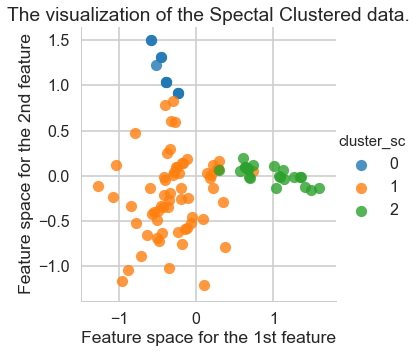

In [21]:
#plot x and y columns of dataframe with color by cluster id
fig1=sns.lmplot('x','y', data=df_pca , hue='cluster_sc',legend=True, fit_reg=False)

#add labels and title
plt.title("The visualization of the Spectal Clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

In [22]:
#fit and predict the labels for scoring
cluster_labels = model.fit_predict(x_cols)

#calculate and print the silhouette score
silhouette_avg_sc = silhouette_score(x_cols, cluster_labels)
print("For Spectal Cluster the average silhouette_score is :", silhouette_avg_sc)

#save score for comparison later
scores_overall['Spectal Cluster']=silhouette_avg_sc

('For Spectal Cluster the average silhouette_score is :', 0.099905912310245787)


This clustering looks rather nice. Cluster 1 does have a higher proportion of points cluster 0 or cluster 2. Lets continue looking at the two other techniques and compare everything we have done at the end.

Next is the Agglomerative Clustering. Per SKLearn documentation, this recursively merges the pair of clusters that minimally increases a given linkage distance. There are three parameters: number of clusters, linkage type,  and distance. Lets once again do out of the box first then we will tune only the number of clusters. The default is 2 for clusters, for distance is euclidean and linkage is ward. Ward minimizes the variance of the clusters being merged. 


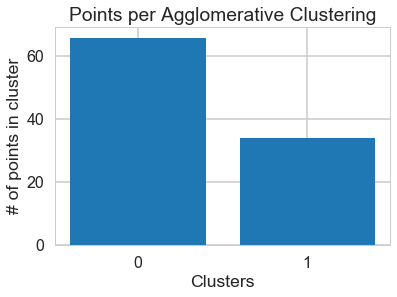

In [65]:
from sklearn.cluster import AgglomerativeClustering

#make an instance of the Agglomerative Clustering
model=AgglomerativeClustering()

#fit: create Agglomerative Clustering on data
model.fit(x_cols)

#save the labels per point to an array
labels=model.labels_
#count the number of points labeled for each cluster

#count the number of points labeled for each cluster
plot_labels=Counter(labels)


#plot the barchart of points per cluster
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_labels)),list(plot_labels.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_labels)),list(plot_labels.keys()))


_ = plt.xlabel('Clusters')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per Agglomerative Clustering')

('For n_clusters =', 2, 'The average silhouette_score is :', 0.082580178231849835)


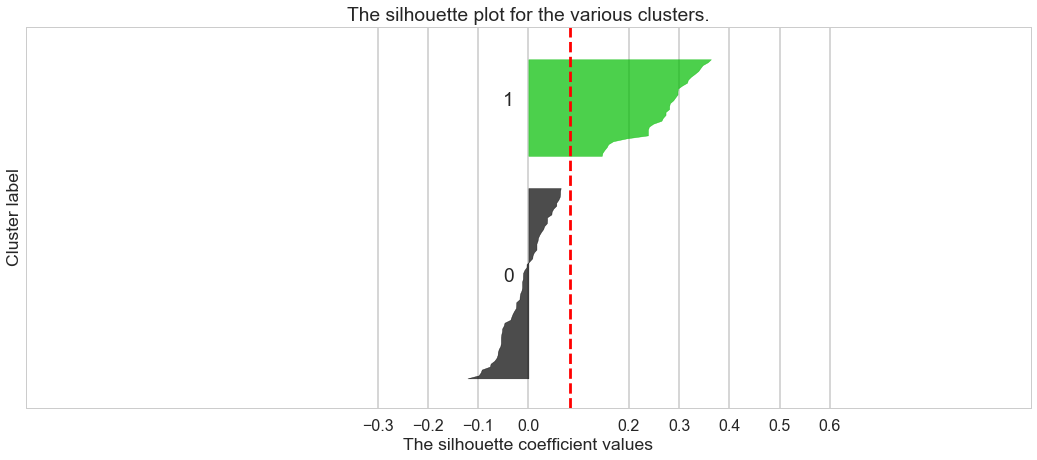

('For n_clusters =', 3, 'The average silhouette_score is :', 0.11625878863607858)


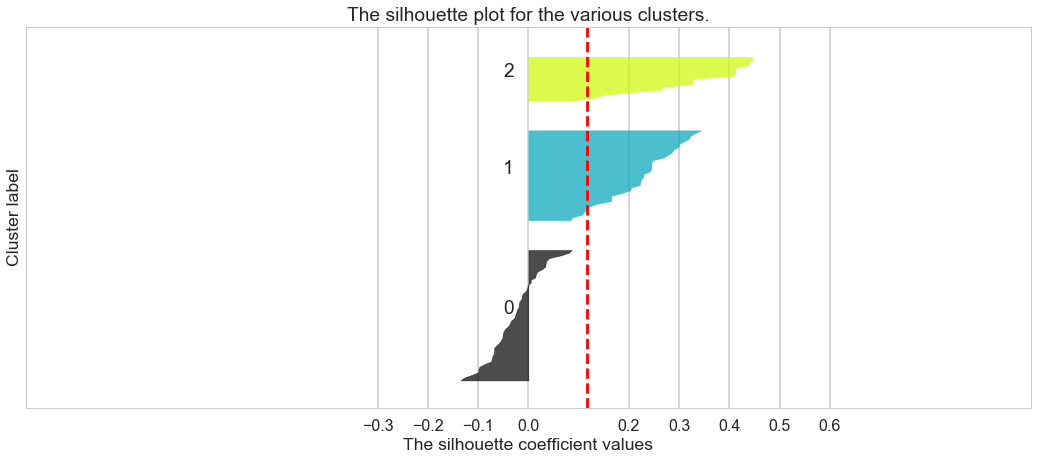

('For n_clusters =', 4, 'The average silhouette_score is :', 0.12893757815881501)


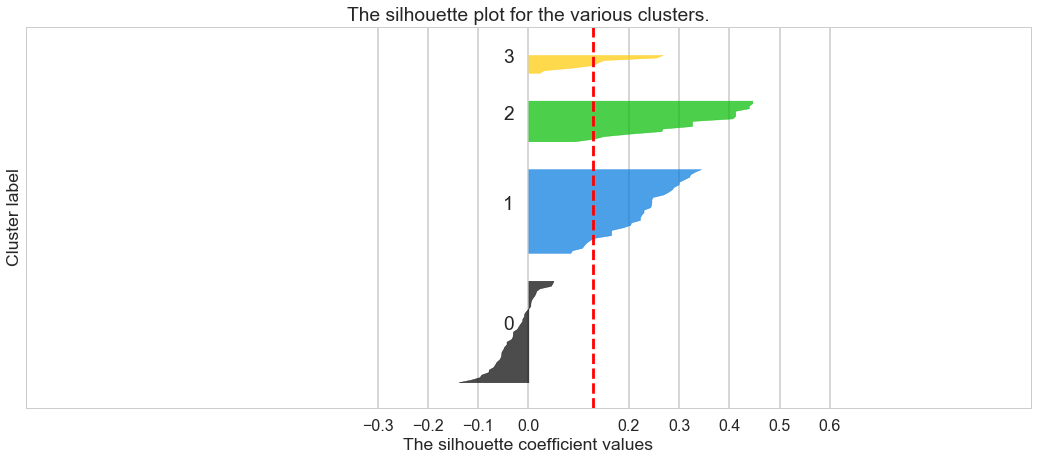

('For n_clusters =', 5, 'The average silhouette_score is :', 0.14089739970831974)


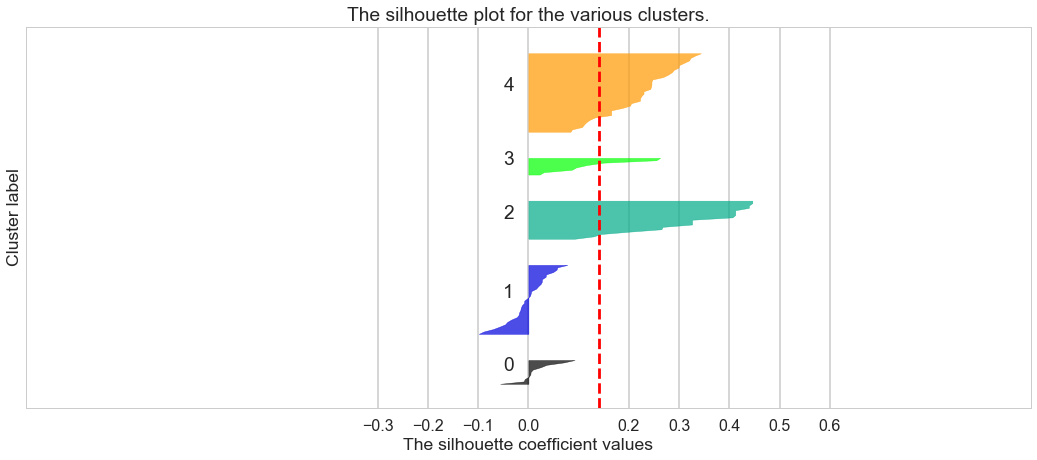

('For n_clusters =', 6, 'The average silhouette_score is :', 0.14715217204613229)


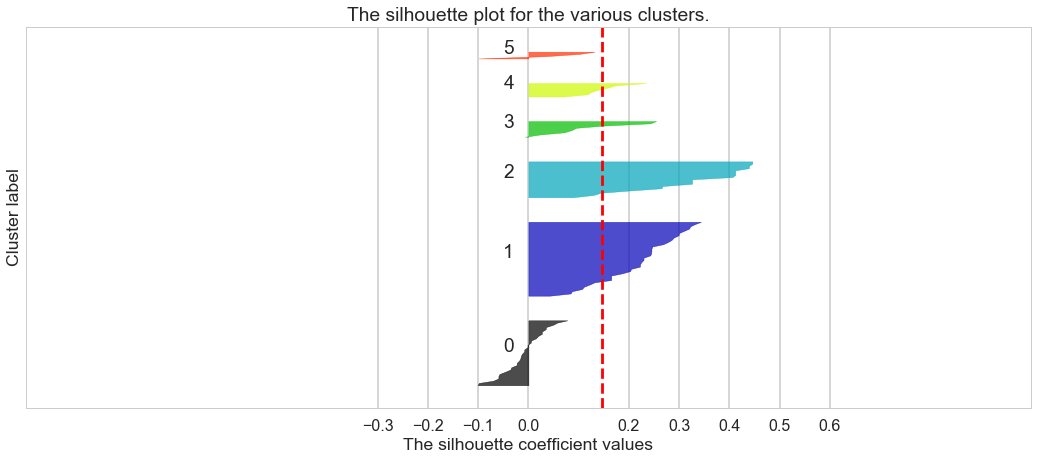

('For n_clusters =', 7, 'The average silhouette_score is :', 0.15275152751051155)


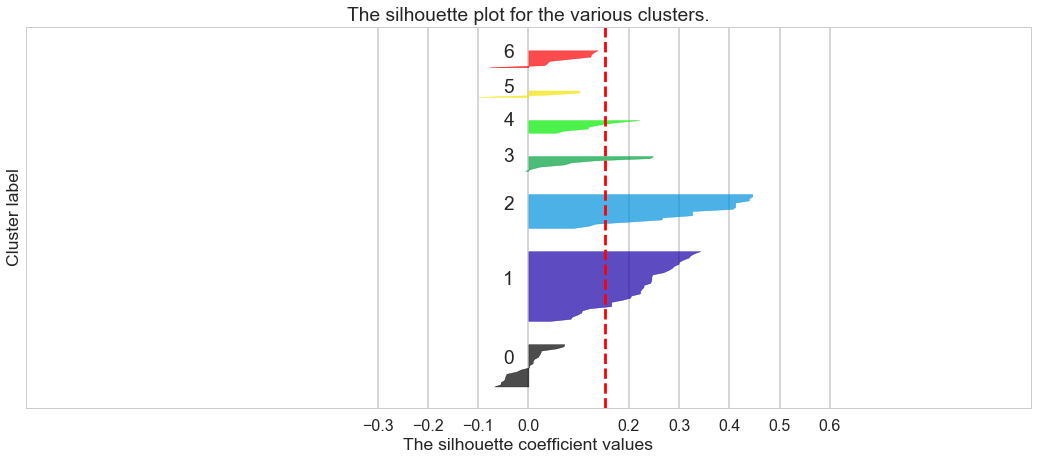

('For n_clusters =', 8, 'The average silhouette_score is :', 0.15578053718604024)


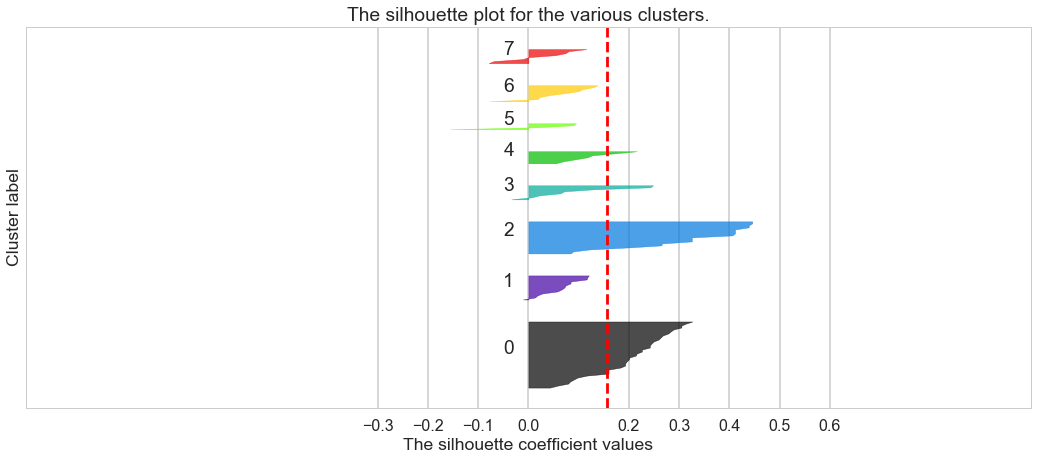

('For n_clusters =', 9, 'The average silhouette_score is :', 0.12075124131971901)


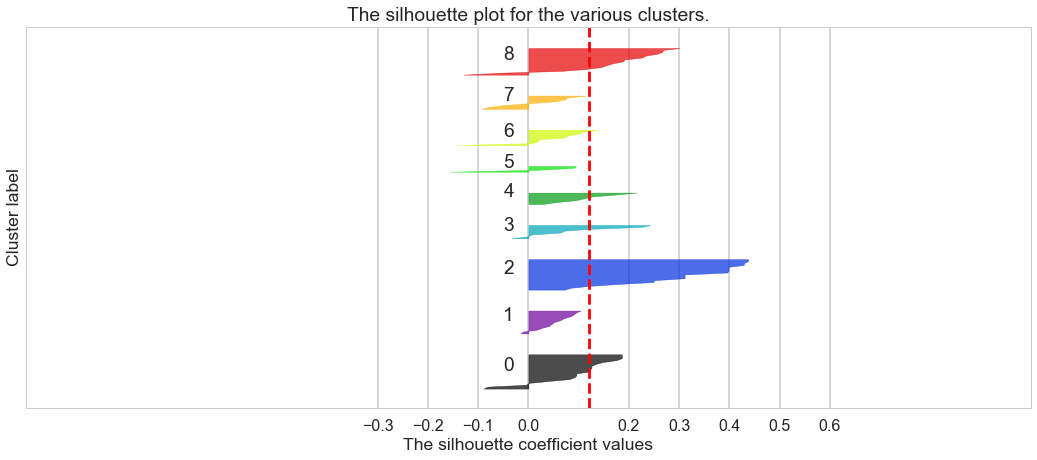

('For n_clusters =', 10, 'The average silhouette_score is :', 0.097547507471477918)


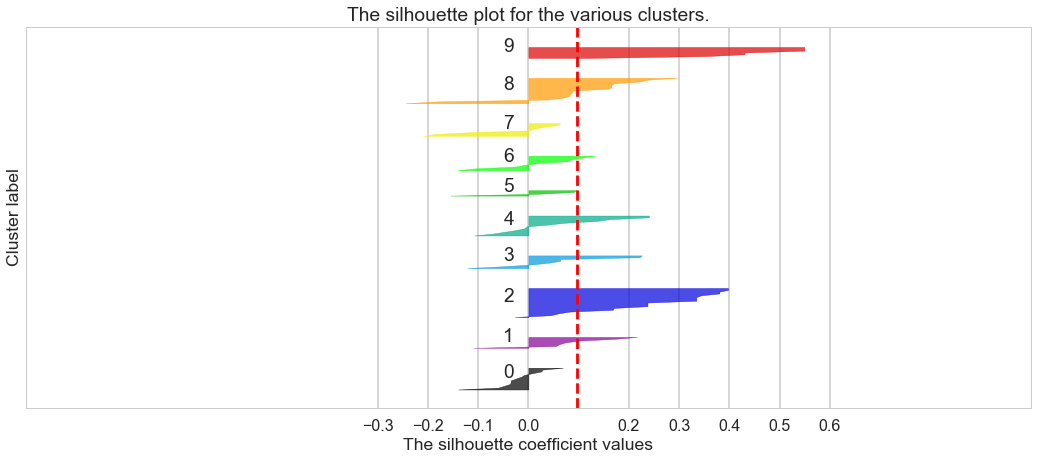

the best number of clusters is 8 with a silhouette_avg of 0.155780537186


In [24]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

#best score holder for k clusters
best_cluster_score=0

#variable to store the best value for k
best_k=0

#loop over cluster numbers to find the best 
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    #capture the best value for the silhouette score and cluster number
    if silhouette_avg > best_cluster_score:
        best_cluster_score = silhouette_avg
        best_k = n_clusters
   
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        #make the size for each cluster on the graph
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #add color to each cluster
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #add labels and title
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #set the ticks for y and x
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3,-0.2,-0.1, 0, 0.2,0.3,0.4,0.5,0.6])
    

    plt.show()
    
#print the best cluster overall along with score
print("the best number of clusters is {} with a silhouette_avg of {}".format(best_k,best_cluster_score))





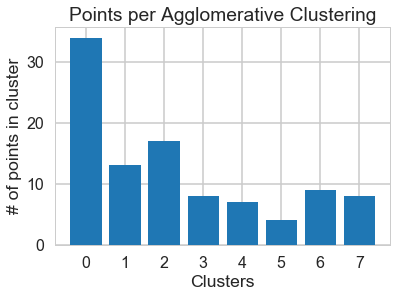

In [64]:

#make an instance of the Agglomerative Clustering
model=AgglomerativeClustering(n_clusters=8)

#fit: create Agglomerative Clustering on data
model.fit(x_cols)

#save the labels per point to an array
labels=model.labels_
#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#plot the barchart of points per cluster
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_labels)),list(plot_labels.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_labels)),list(plot_labels.keys()))


_ = plt.xlabel('Clusters')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per Agglomerative Clustering')

plt.show()

In [26]:
#save Agglomerative Clustering Labels to dataframe
df_pca['cluster_ac']=labels

/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


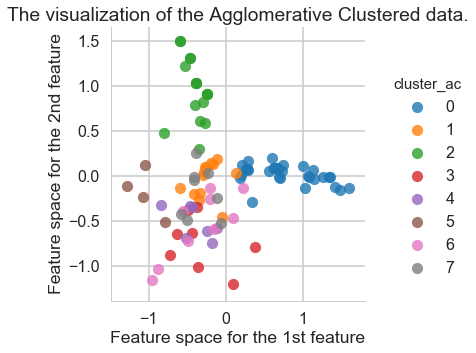

In [27]:
#plot x and y columns of dataframe with color by cluster id
sns.lmplot('x','y', data=df_pca , hue='cluster_ac',legend=True, fit_reg=False)

#add labels and title
plt.title("The visualization of the Agglomerative Clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

In [28]:
#fit and predict labels for scoring
cluster_labels = model.fit_predict(x_cols)

#calculate and print silhouette score
silhouette_avg_ac = silhouette_score(x_cols, cluster_labels)
print("For Agglomerative Cluster the average silhouette_score is :", silhouette_avg_ac)

#save score for comparison later
scores_overall['Agglomerative Cluster']=silhouette_avg_ac

('For Agglomerative Cluster the average silhouette_score is :', 0.15578053718604024)



Finally, we look at Density-Based Spatial Clustering of Applications with Noise (DBSCAN). Per SKLearn documentation, this finds core samples of high density and expands clusters from them. Knowledge of cluster centers is not required but neighborhood size is. Thus, neighborhood size is the one parameter for tuning. Once again we will do out of the box and then tune the parameter. The default is 0.5 for eps, maximum distance between two samples for them to be considered as in the same neighborhood, distance is euclidean, and leaf size is 30. 

DBSCAN accepts an array or matrix. We have been plotting the PCA 2 componenet dimension reduction, so we shall continue in that theme and pass the DBSCAN the array of pca features as the x and y cluster points. DBSCAN will use this points and beginning with a random point assign neighborhood based on the size of epa we pass (default 0.5). The min_samples is the minimum number of data points we want in a neighborhood to define a cluster. We shall tune both of these parameters after the initial out of the box run.  The DBSCAN classifies points into three catagories core points, border points, and outlier points (noise). Core points are those within the radius meet the density requirement. Border points are points that just outside this raduis of density but still reachable by the set eplison. Noise is well noise. 

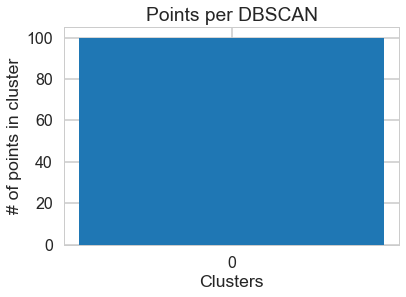

In [58]:
from sklearn.cluster import DBSCAN

#make an instance of the DBSCAN
model=DBSCAN()

#fit: create DBSCAN on data
model.fit(pca_features)

#save the labels per point to an array
labels=model.labels_
#count the number of points labeled for each cluster
plot_labels=Counter(labels)

#plot the barchart of points per cluster
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(plot_labels)),list(plot_labels.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(plot_labels)),list(plot_labels.keys()))


_ = plt.xlabel('Clusters')
_ = plt.ylabel('# of points in cluster')
_ = plt.title('Points per DBSCAN')

plt.show()



This is just terrible, but see saw similiar terrible examples for the random forest and the initial naive bayes. Lets do some tuning. 

('For n_eps =', 0.05, 'The average silhouette_score is :', -0.14782809691065699)


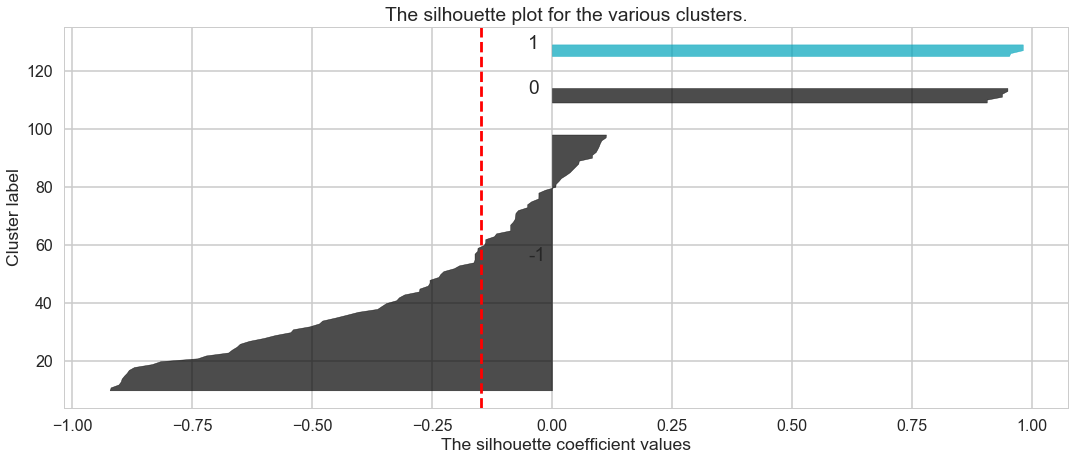

('For n_eps =', 0.1, 'The average silhouette_score is :', -0.12186968093912709)


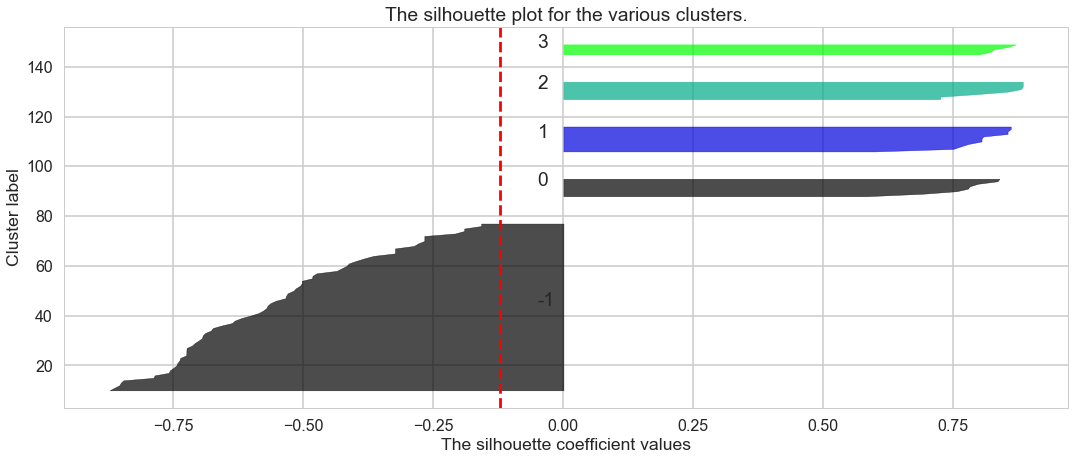

('For n_eps =', 0.15, 'The average silhouette_score is :', 0.15329553120728742)


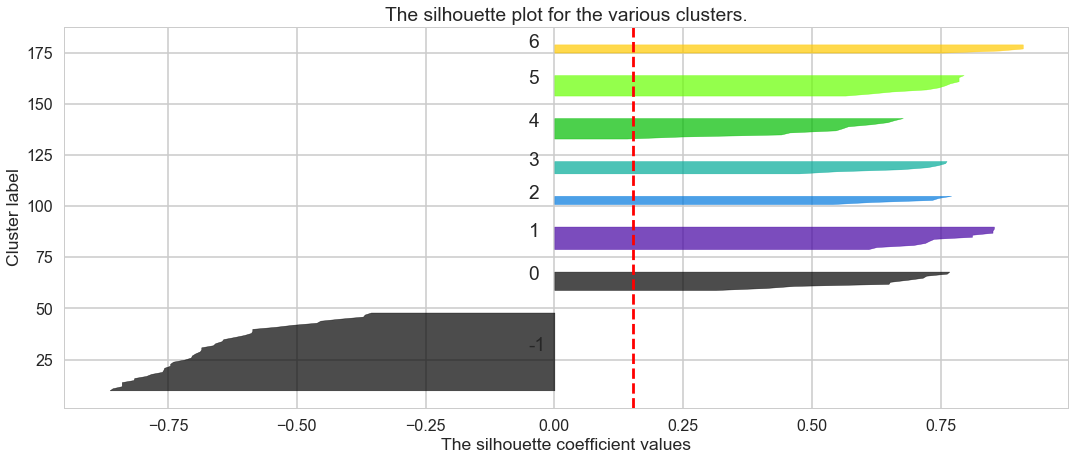

('For n_eps =', 0.25, 'The average silhouette_score is :', 0.42816025364356514)


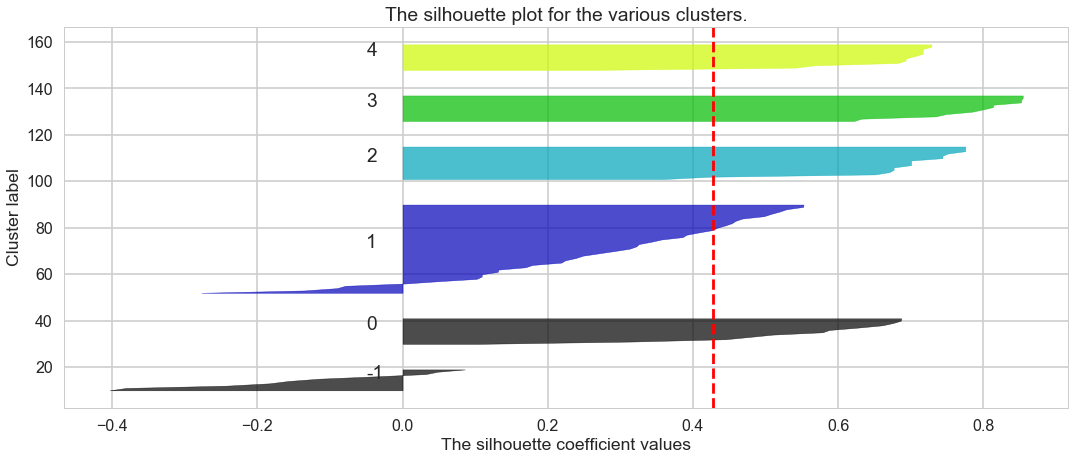

neighborhood distance is to far to cluster appropriately for 0.5 only 1 clusters
neighborhood distance is to far to cluster appropriately for 0.75 only 1 clusters
neighborhood distance is to far to cluster appropriately for 1 only 1 clusters
The best number of clusters is 0.25 with a silhouette_avg of 0.428160253644


In [30]:
#range of neighborhood size to consider
range_eps=[0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1]

#best score holder for k clusters
best_cluster_score=0

#variable to store the best value for eps
best_k=0

#loop over n_size to find the best 
for n_eps in range_eps:
    
    # Initialize the clusterer with eps value, 
    clusterer = DBSCAN(eps=n_eps)
    
    #save fitted and predicted labels 
    cluster_labels = clusterer.fit_predict(pca_features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    
    #calculate number of clusters by counter on key values
    clusters=len(Counter(cluster_labels).keys())
    
    #calculate silhouette score per sample only if more than one label/cluster
    if clusters > 2:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
      

        silhouette_avg = silhouette_score(pca_features, cluster_labels)
        print("For n_eps =", n_eps,
          "The average silhouette_score is :", silhouette_avg)
    
    #capture the best value for the silhouette score and cluster number
        if silhouette_avg > best_cluster_score:
            best_cluster_score = silhouette_avg
            best_k = n_eps
   
    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pca_features, cluster_labels)
        y_lower = 10
    #calculate number of clusters
        clusters=len(Counter(cluster_labels).keys())
    
        for i in range(-1,clusters-1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

        #make the size for each cluster on the graph
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

        #add color to each cluster
            color = cm.spectral(float(i) / clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

    #add labels and title
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        plt.show()
    
    #if only one label/cluster print value of eps and we did not score
    else:
        print('neighborhood distance is to far to cluster appropriately for {} only {} clusters'.format(n_eps,clusters))
    
#print the best cluster overall along with score
print("The best number of clusters is {} with a silhouette_avg of {}".format(best_k,best_cluster_score))






In [31]:
silhouette_avg_ac

0.15578053718604024

In [32]:
#make an instance of the Spectal Clustering 
model=DBSCAN(eps=best_k)

#fit Spectal Clustering to data
model.fit(pca_features)

#save the labels per point to an array
labels=model.labels_

#count the number of points labeled for each cluster
plot_labels=Counter(labels)

In [33]:
#save fitted and predicted labels 
cluster_labels = model.fit_predict(pca_features)
#calculate teh silhouette score for Affinity Cluster Method
silhouette_avg_dbscan = silhouette_score(pca_features, cluster_labels)
print("For Affinity Cluster the average silhouette_score is :", silhouette_avg_dbscan)

#save score for comparison later
scores_overall['DBSCAN']=silhouette_avg_dbscan



('For Affinity Cluster the average silhouette_score is :', 0.42816025364356514)


In [34]:
df_pca['dbscan']=labels

/Users/luca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
df_pca.head()

offer_id,customer_name,x,y,cluster_id,cluster_af,cluster_sc,cluster_ac,dbscan
0,Adams,1.007580,0.108215,2,0,2,0,0
1,Allen,-0.287539,0.044715,1,10,1,1,1
2,Anderson,-0.392032,1.038391,3,6,0,2,2
3,Bailey,0.699477,-0.022542,2,3,2,0,3
4,Baker,0.088183,-0.471695,1,3,1,6,1


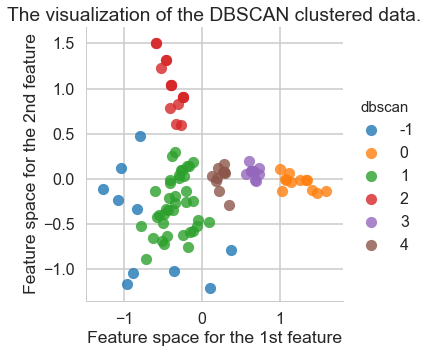

In [36]:
#plot x and y columns of dataframe with color by cluster id
sns.lmplot('x','y', data=df_pca , hue='dbscan',legend=True, fit_reg=False)

#add labels and title
plt.title("The visualization of the DBSCAN clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

We see that the DBSCAN a very nice job clustering when tuned. The blue points is the outliers. All the other clusters are easily destinguished and the points are close packed together. 

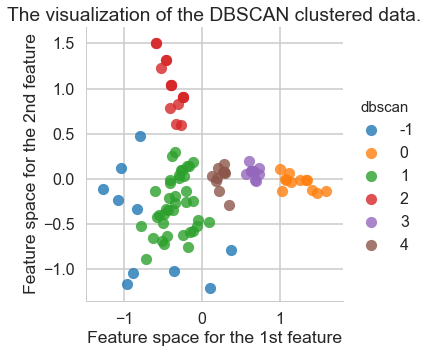

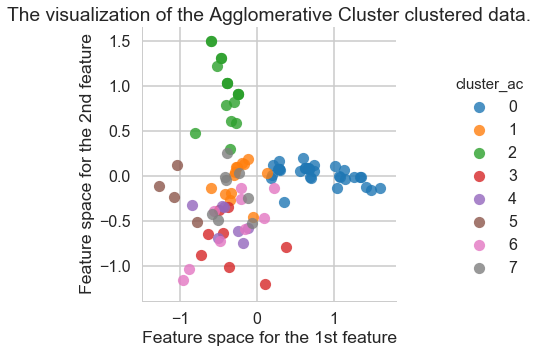

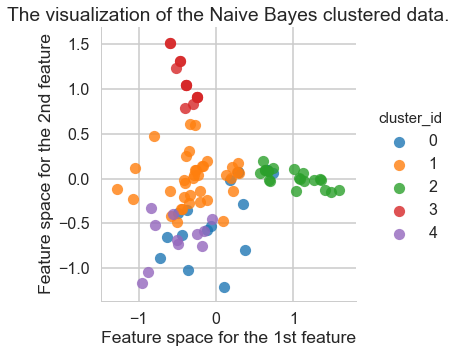

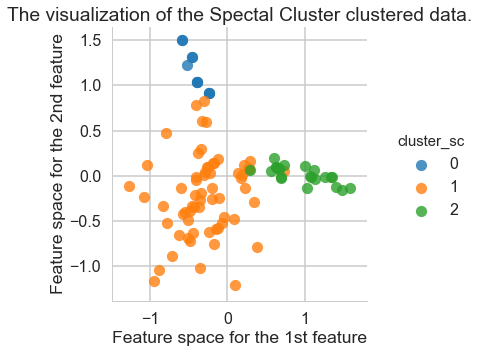

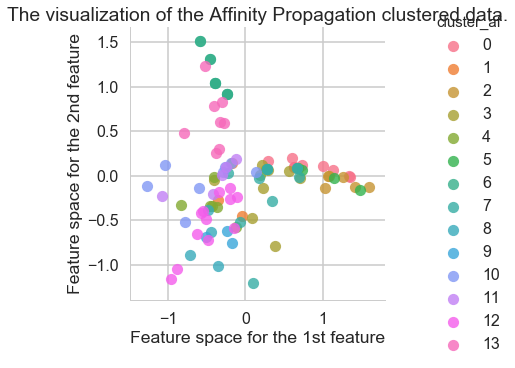

In [37]:
cluster_graphes={'cluster_id':'Naive Bayes','cluster_af':'Affinity Propagation','cluster_sc':'Spectal Cluster','cluster_ac':'Agglomerative Cluster','dbscan':'DBSCAN'}
for k in cluster_graphes:
    sns.lmplot('x','y', data=df_pca , hue=k,legend=True, fit_reg=False)
    #add labels and title
    plt.title("The visualization of the {} clustered data.".format(cluster_graphes[k]))
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")
    plt.show()

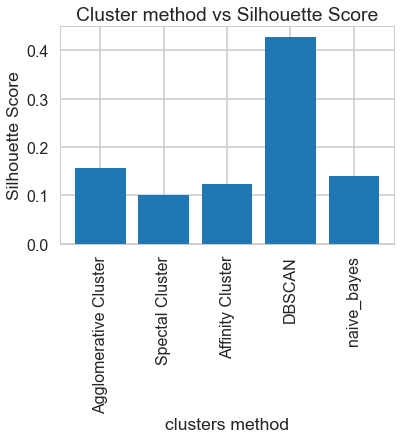

In [49]:
#plot best score from each cluster from scores_overall dict
#get x-axis range from len and make a list of the dict values
plt.bar(range(len(scores_overall)),list(scores_overall.values()))

#match score with key value and label x-axis appropriately
plt.xticks(range(len(scores_overall)),list(scores_overall.keys()),rotation='vertical')

#add title and lables
_ = plt.xlabel('clusters method')
_ = plt.ylabel('Silhouette Score')
_ = plt.title('Cluster method vs Silhouette Score')
plt.show()

Visually the DBSCAN does very nice as well. We would want to see cluster that are well defined and closely gathered together. DBSCAN does this exceptionally well. Most of the clusters are closely packed together with no overlap. The outliers are a concern; there are quite a few that don't fit neatly together or close to one another. However, we could consider this an irregular cluster, a half moon shaped cluster. The second best vizual cluster is the Spectal Cluster which groups 3 very nice cluster with little overlap. However, the orange colored group is rather large. 
    
We have looked at 5 different clustering methods with a varying degree of detail. The best method we obtained was with the DBSCAN which performed best by both of our metrics, visual 2-d pca feature plotting and silhouette score. The bar chart illustrates the overwhelming perform of the dbscan. This is not to surprising sense the silhouette is a measure of how dense a cluster. Dense here is a measure of how similiar points in a cluster are to points in that cluster. This is exactly what the DBSCAN tries to optimize. The final verdict goes to DBSCAN for now. However, we could try to continue tuning the other methods for better results in the future. 
    